# Rocket Trajectory Simulation - RocketPy Example Notebook

# First Simulation

## Initialization Cells

In [1]:
%load_ext autoreload
%autoreload 2
%load_ext snakeviz

In [4]:
%matplotlib notebook
plt.rcParams.update({'figure.max_open_warning': 0})

## Importing RocketPy

In [3]:
from rocketpyAlpha import *

## Setting up Simulation

### Creating an Environment

In [5]:
Env = Environment(railLength=5.2,
              gravity=9.8,
              windData="../data/weather/SpacePort.nc",
              location=(32.990254, -106.974998),
              date=(2016, 6, 20, 18))

### Creating a Motor

In [6]:
Pro75M1670 = Motor(thrustSource="../data/motors/Cesaroni_M1670.eng",
               burnOut=3.9,
               grainNumber=5,
               grainSeparation=5/1000,
               grainDensity=1815,
               grainOuterRadius=33/1000,
               grainInitialInnerRadius=15/1000,
               grainInitialHeight=120/1000,
               nozzleRadius=33/1000,
               throatRadius=11/1000,
               interpolationMethod='linear')

### Creating a Rocket

In [65]:
Calisto = Rocket(motor=Pro75M1670,
             radius=127/2000,
             mass=19.197-2.956,
             inertiaI=6.60,
             inertiaZ=0.0351,
             distanceRocketNozzle=-1.255,
             distanceRocketPropellant=-0.85704,
             powerOffDrag='../data/calisto/powerOffDragCurve.csv',
             powerOnDrag='../data/calisto/powerOnDragCurve.csv')

### Adding Aerodynamic Surfaces

In [66]:
NoseCone = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)

FinSet = Calisto.addFins(4, span=0.100, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)

Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

### Adding Parachutes

In [67]:
def drogueTrigger(p, y):
    return True if y[5] < 0 else False

def mainTrigger(p, y):
    return True if y[5] < 0 and y[2] < 800 else False

Main = Calisto.addParachute('Main',
                            CdS=10.0,
                            trigger=mainTrigger, 
                            samplingRate=105,
                            lag=1.5)

Drogue = Calisto.addParachute('Drogue',
                              CdS=1.0,
                              trigger=drogueTrigger, 
                              samplingRate=105,
                              lag=1.5)

## Simulate Flight

In [68]:
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, verbose=False)

## Analyse the Results


Off Rail Conditions
Rail Departure Time: 0.416 s
Rail Departure Velocity: 30.533 m/s

Apogee
Altitude: 3147.073 m
Velocity: 19.371 m/s
Time: 25.089 s
Freestream Speed: 22.680 m/s

Events
Drogue Ejection Triggered at: 25.095 s
Drogue Parachute Inflated at: 26.595 s
Drogue Parachute Inflated with Freestream Speed of: 26.840 m/s
Drogue Parachute Inflated at Height of: 3136.135 m
Main Ejection Triggered at: 158.343 s
Main Parachute Inflated at: 159.843 s
Main Parachute Inflated with Freestream Speed of: 17.842 m/s
Main Parachute Inflated at Height of: 773.216 m

Impact
X Impact: -958.128 m
Y Impact: 997.727 m
Time of Impact: 296.049 s
Velocity at Impact: -5.642 m/s

Maximum Velocity and Acceleration
Velocity: 283.560 m/s
Acceleration: 104.801 m/s2

Trajectory Plots


<IPython.core.display.Javascript object>


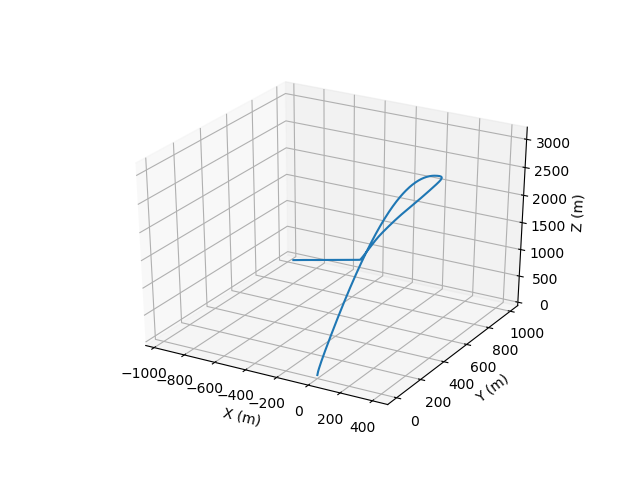

In [69]:
TestFlight.info()

# Using Simulation for Design

### Dynamic Stability Analysis

Simulating Rocket with Static Margin of -1.444->-0.405 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of -0.046->0.993 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 1.352->2.391 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 2.750->3.789 c
Simulation Completed at Time: 5.0000 s
Simulating Rocket with Static Margin of 4.147->5.186 c
Simulation Completed at Time: 5.0000 s


<IPython.core.display.Javascript object>


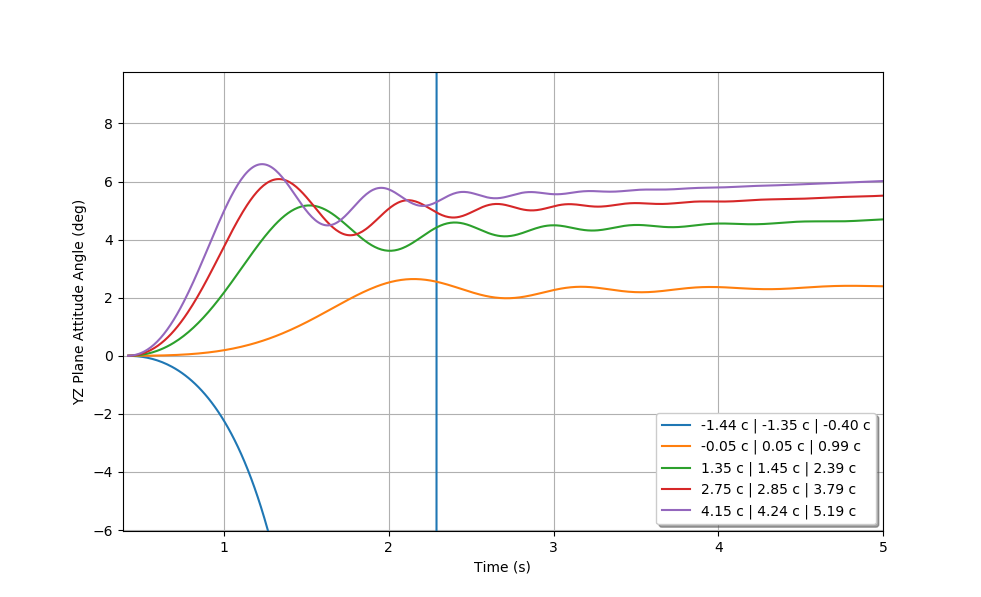

In [111]:
# Prepare Rocket Class
Calisto = Rocket(motor=Pro75M1670,
                     radius=127/2000,
                     mass=19.197-2.956,
                     inertiaI=6.60,
                     inertiaZ=0.0351,
                     distanceRocketNozzle=-1.255,
                     distanceRocketPropellant=-0.85704,
                     powerOffDrag='../data/calisto/powerOffDragCurve.csv',
                     powerOnDrag='../data/calisto/powerOnDragCurve.csv')
Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

# Prepare Environment Class
Env = Environment(5.2, 9.8, (5, 180))

# Simulate Different Static Margins by Varying Fin Position
simulation_results = []

for factor in [0.5, 0.7, 0.9, 1.1, 1.3]:
    # Modify rocket fin set by removing previous one and adding new one
    Calisto.aerodynamicSurfaces.remove(FinSet)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956*factor)
    # Simulate
    print('Simulating Rocket with Static Margin of {:1.3f}->{:1.3f} c'.format(Calisto.staticMargin(0), Calisto.staticMargin(Calisto.motor.burnOutTime)))
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5, terminateOnApogee=True, verbose=True)
    # Post process flight data
    TestFlight.postProcess()
    # Store Results
    staticMarginAtIginition = Calisto.staticMargin(0)
    staticMarginAtOutOfRail = Calisto.staticMargin(TestFlight.outOfRailTime)
    staticMarginAtSteadyState = Calisto.staticMargin(TestFlight.tFinal)
    simulation_results += [(TestFlight.trajectoryAngleYZ, '{:1.2f} c | {:1.2f} c | {:1.2f} c'.format(staticMarginAtIginition, staticMarginAtOutOfRail, staticMarginAtSteadyState))]

Function.comparePlots(simulation_results, xlabel='Time (s)', ylabel='YZ Plane Attitude Angle (deg)')

## Characteristic Frequency Calculation

<IPython.core.display.Javascript object>


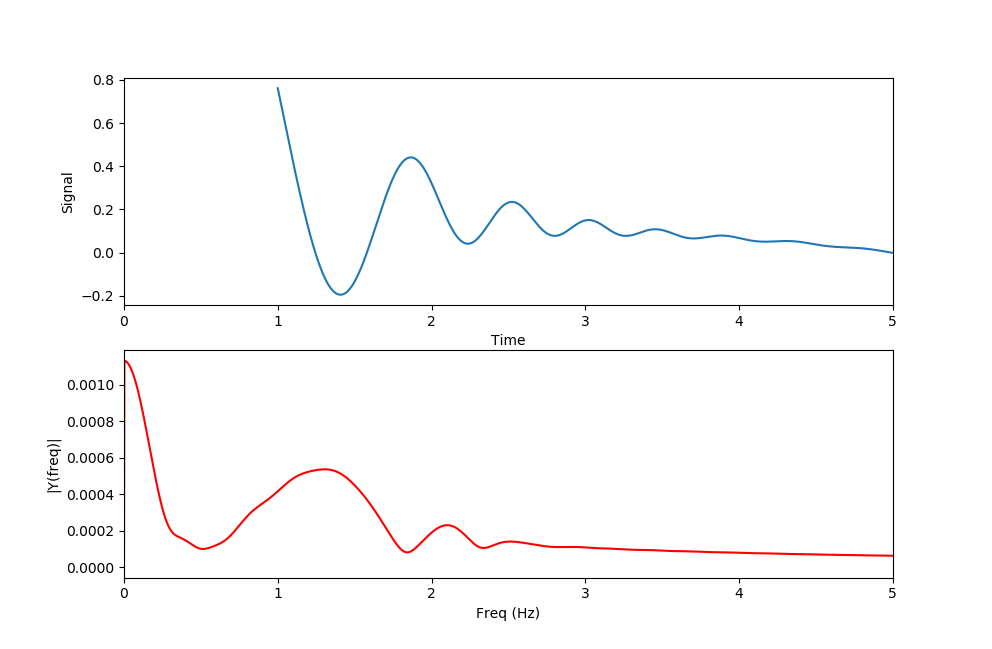

(0, 5)

In [107]:
# Prepare Environment
Env = Environment(railLength=5.2,
              gravity=9.8,
              windData="../data/weather/SpacePort.nc",
              location=(32.990254, -106.974998),
              date=(2016, 6, 20, 18))

# Prepare Motor
Pro75M1670 = Motor(thrustSource="../data/motors/Cesaroni_M1670.eng",
               burnOut=3.9,
               grainNumber=5,
               grainSeparation=5/1000,
               grainDensity=1815,
               grainOuterRadius=33/1000,
               grainInitialInnerRadius=15/1000,
               grainInitialHeight=120/1000,
               nozzleRadius=33/1000,
               throatRadius=11/1000,
               interpolationMethod='linear')

# Prepare Rocket
Calisto = Rocket(motor=Pro75M1670,
                     radius=127/2000,
                     mass=19.197-2.956,
                     inertiaI=6.60,
                     inertiaZ=0.0351,
                     distanceRocketNozzle=-1.255,
                     distanceRocketPropellant=-0.85704,
                     powerOffDrag='../data/calisto/powerOffDragCurve.csv',
                     powerOnDrag='../data/calisto/powerOnDragCurve.csv')
Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

# Simulate first 10 seconds of Flight
TestFlight = Flight(rocket=Calisto, environment=Env, inclination=90, heading=0, maxTimeStep=0.01, maxTime=5)
TestFlight.postProcess()

# Perform a Fourier Analysis
Fs = 100.0;  # sampling rate
Ts = 1.0/Fs; # sampling interval
t = np.arange(1,400,Ts) # time vector
ff = 5;   # frequency of the signal
y = TestFlight.trajectoryAngleYZ(t) - np.mean(TestFlight.trajectoryAngleYZ(t))
n = len(y) # length of the signal
k = np.arange(n)
T = n/Fs
frq = k/T # two sides frequency range
frq = frq[range(n//2)] # one side frequency range
Y = np.fft.fft(y)/n # fft computing and normalization
Y = Y[range(n//2)]
fig, ax = plt.subplots(2, 1)
ax[0].plot(t,y)
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Signal')
ax[0].set_xlim((0, 5))
ax[1].plot(frq,abs(Y),'r') # plotting the spectrum
ax[1].set_xlabel('Freq (Hz)')
ax[1].set_ylabel('|Y(freq)|')
ax[1].set_xlim((0, 5))

## Apogee as a Function of Mass

<IPython.core.display.Javascript object>


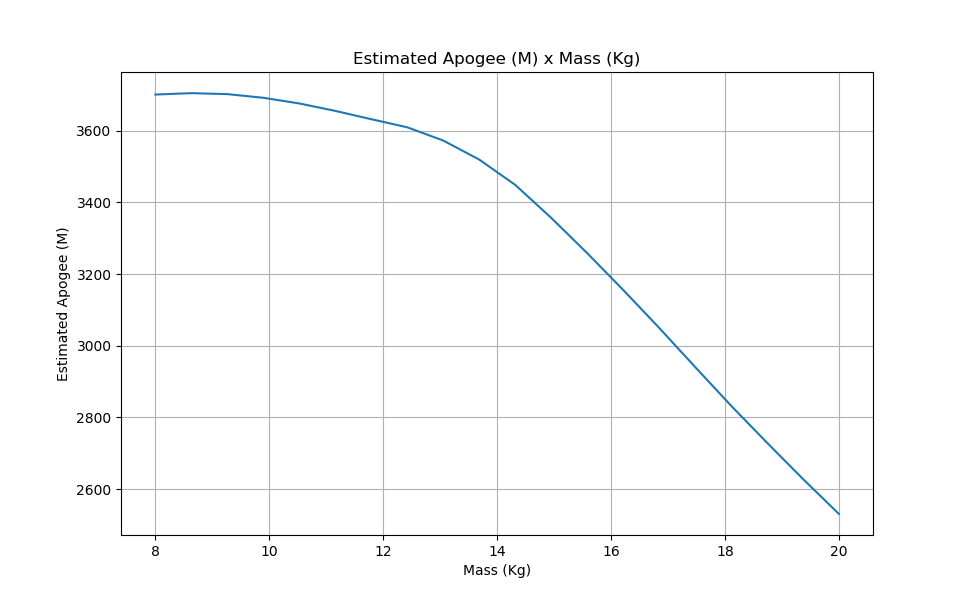

In [122]:
def apogee(mass):
    # Prepare Environment
    Env = Environment(railLength=5.2,
                  gravity=9.8,
                  windData="../data/weather/SpacePort.nc",
                  location=(32.990254, -106.974998),
                  date=(2016, 6, 20, 18))

    # Prepare Motor
    Pro75M1670 = Motor(thrustSource="../data/motors/Cesaroni_M1670.eng",
                   burnOut=3.9,
                   grainNumber=5,
                   grainSeparation=5/1000,
                   grainDensity=1815,
                   grainOuterRadius=33/1000,
                   grainInitialInnerRadius=15/1000,
                   grainInitialHeight=120/1000,
                   nozzleRadius=33/1000,
                   throatRadius=11/1000,
                   interpolationMethod='linear')

    # Prepare Rocket
    Calisto = Rocket(motor=Pro75M1670,
                         radius=127/2000,
                         mass=mass,
                         inertiaI=6.60,
                         inertiaZ=0.0351,
                         distanceRocketNozzle=-1.255,
                         distanceRocketPropellant=-0.85704,
                         powerOffDrag='../data/calisto/powerOffDragCurve.csv',
                         powerOnDrag='../data/calisto/powerOnDragCurve.csv')
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
    Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.apogee

apogeebymass = Function(apogee, inputs="Mass (kg)", outputs="Estimated Apogee (m)")
apogeebymass.plot(8,20,20)

## Out of Rail Speed as a Function of Mass

<IPython.core.display.Javascript object>


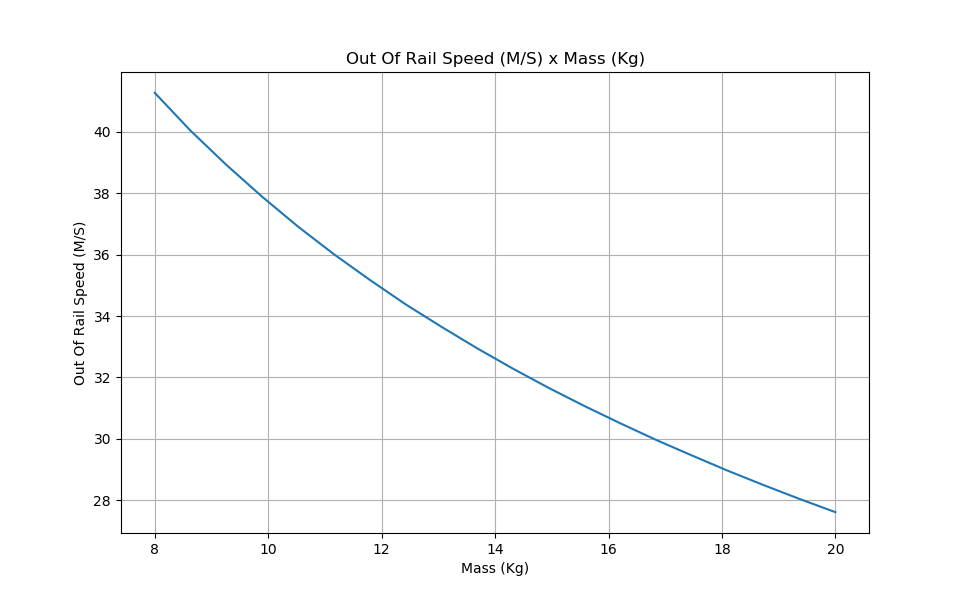

In [124]:
def speed(mass):
    # Prepare Environment
    Env = Environment(railLength=5.2,
                  gravity=9.8,
                  windData="../data/weather/SpacePort.nc",
                  location=(32.990254, -106.974998),
                  date=(2016, 6, 20, 18))

    # Prepare Motor
    Pro75M1670 = Motor(thrustSource="../data/motors/Cesaroni_M1670.eng",
                   burnOut=3.9,
                   grainNumber=5,
                   grainSeparation=5/1000,
                   grainDensity=1815,
                   grainOuterRadius=33/1000,
                   grainInitialInnerRadius=15/1000,
                   grainInitialHeight=120/1000,
                   nozzleRadius=33/1000,
                   throatRadius=11/1000,
                   interpolationMethod='linear')

    # Prepare Rocket
    Calisto = Rocket(motor=Pro75M1670,
                         radius=127/2000,
                         mass=mass,
                         inertiaI=6.60,
                         inertiaZ=0.0351,
                         distanceRocketNozzle=-1.255,
                         distanceRocketPropellant=-0.85704,
                         powerOffDrag='../data/calisto/powerOffDragCurve.csv',
                         powerOnDrag='../data/calisto/powerOnDragCurve.csv')
    Nose = Calisto.addNose(length=0.55829, kind="vonKarman", distanceToCM=0.71971)
    FinSet = Calisto.addFins(4, span=0.1, rootChord=0.120, tipChord=0.040, distanceToCM=-1.04956)
    Tail = Calisto.addTail(topRadius=0.0635, bottomRadius=0.0435, length=0.060, distanceToCM=-1.194656)

    # Simulate Flight until Apogee
    TestFlight = Flight(rocket=Calisto, environment=Env, inclination=85, heading=0, terminateOnApogee=True)
    return TestFlight.outOfRailVelocity

speedbymass = Function(speed, inputs="Mass (kg)", outputs="Out of Rail Speed (m/s)")
speedbymass.plot(8,20,20)